In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from tqdm import trange
import copy
import pickle, random
import librosa 

from IPython.display import Audio
import soundfile as sf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)

True
11.7
1.13.1


### MNIST data

In [47]:
def view_training_graphs(training_loss, validation_loss, validation_accuracy, title = ''):
    # Create a figure with two subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    # Plot the training loss
    ax1.plot(training_loss, color='blue')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Training Loss')

    # Plot the validation loss
    ax2.plot(validation_loss, color='blue')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Validation Loss')

    # Plot the validation accuracy
    ax3.plot(validation_accuracy, color='red')
    ax3.set_xlabel('Epoch')
    ax3.set_title('Validation Accuracy')

    # Display the figure
    fig.suptitle(title)
    plt.tight_layout()
    
    return plt.show()

In [3]:
# Load the training data from trs.pkl
with open('trs.pkl', 'rb') as trs_file:
    trs = pickle.load(trs_file)

# Load the test data from tes.pkl
with open('tes.pkl', 'rb') as tes_file:
    tes = pickle.load(tes_file)

In [63]:
len(trs)

500

In [4]:
num_utterances = 10  # Number of utterances per speaker

In [5]:
S=librosa.stft(tes[0], n_fft=1024, hop_length=512)
S.shape


(513, 45)

In [67]:
positive_pairs, negative_pairs = [], []
for speaker in range(len(trs) // num_utterances):
    exclude_range = list(range(speaker * num_utterances, speaker * num_utterances + num_utterances))
    available_indices = [x for x in list(range(len(trs))) if x not in exclude_range]
    for i in range(10):
        for j in range(i + 1, 10):
            positive_pairs.append((trs[speaker * num_utterances + i], trs[speaker * num_utterances + j], 1))
            negative_pairs.append((trs[random.choice(exclude_range)], trs[random.choice(available_indices)], 0))

print(len(positive_pairs), len(negative_pairs))

2250 2250


In [68]:
positive_pairs_val, negative_pairs_val = [], []
for speaker in range(len(tes) // num_utterances):
    exclude_range = list(range(speaker * num_utterances, speaker * num_utterances + num_utterances))
    available_indices = [x for x in list(range(len(tes))) if x not in exclude_range]
    for i in range(10):
        for j in range(i + 1, 10):
            positive_pairs_val.append((tes[speaker * num_utterances + i], tes[speaker * num_utterances + j], 1))
            negative_pairs_val.append((tes[random.choice(exclude_range)], tes[random.choice(available_indices)], 0))

print(len(positive_pairs_val), len(negative_pairs_val))

900 900


In [8]:
pairs_train = positive_pairs + negative_pairs
random.shuffle(pairs_train)

pairs_val = positive_pairs_val + negative_pairs_val
random.shuffle(pairs_val)

In [69]:
def pad_or_trim(spectrogram, max_time_frames, axis=1):
    if spectrogram.shape[axis] < max_time_frames:
        # Pad the spectrogram with zeros at the end to match the max_time_frames along the specified axis
        pad_width = [(0, 0)] * len(spectrogram.shape)
        pad_width[axis] = (0, max_time_frames - spectrogram.shape[axis])
        padded = np.pad(spectrogram, pad_width, mode='constant')
        return padded
    elif spectrogram.shape[axis] > max_time_frames:
        # Trim the spectrogram to match the max_time_frames along the specified axis
        if axis == 0:
            trimmed = spectrogram[:max_time_frames, :]
        else:
            trimmed = spectrogram[:, :max_time_frames]
        return trimmed
    else:
        # No change needed if the spectrogram already has the desired shape
        return spectrogram

In [70]:
max_time_frames = 45

In [107]:
# Define a custom dataset for loading the pairs
class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, pairs, transform=True):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        utterance1, utterance2, label = self.pairs[index]
        if self.transform:
            
            utterance1_S = librosa.stft(utterance1, n_fft=1024, hop_length=512)
            utterance1_S = pad_or_trim(utterance1_S, max_time_frames)
            utterance1_S_tensor = torch.tensor(np.abs(utterance1_S), dtype = torch.float32)
            
            utterance2_S = librosa.stft(utterance2, n_fft=1024, hop_length=512)
            utterance2_S = pad_or_trim(utterance2_S, max_time_frames)
            utterance2_S_tensor = torch.tensor(np.abs(utterance2_S), dtype = torch.float32)
        
        return utterance1_S_tensor.T, utterance2_S_tensor.T, label

batch_size = 32
# Create a data loader for training
train_dataset = SiameseDataset(pairs_train)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

# Create a data loader for training
val_dataset = SiameseDataset(pairs_val)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

In [108]:
class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()
        self.gru1 = nn.GRU(input_size=513, hidden_size=512, batch_first=True)
        self.gru2 = nn.GRU(input_size=512, hidden_size=512, batch_first=True)
        self.out = nn.Linear(512 * 45, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.5)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.kaiming_normal_(self.out.weight)
    
    def output(self, o1, o2):
        x = o1 * o2
        x = torch.flatten(x, 1) 
        return torch.sigmoid(self.out(x))

    def forward(self, x):
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        return x  

In [109]:
def validate_siamese_model(model, criterion, valloader):
    with torch.no_grad():
        correct, total, running_validation_loss = 0, 0, 0
        for i, (audio1, audio2, labels) in enumerate(valloader):
            audio1, audio2, labels = audio1.to(device), audio2.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            o1, o2 = model(audio1), model(audio2)
            outputs = model.output(o1, o2)
            loss = criterion(outputs, labels)
            running_validation_loss += loss.item()
            predicted = torch.round(outputs)
            total += len(labels)
            correct += (predicted == labels).sum()
        
        validation_accuracy = 100 * correct / total
        total_validation_loss = (running_validation_loss) / len(valloader)
        return validation_accuracy.cpu().numpy(), total_validation_loss

In [110]:
# common function to train and validate
def train_siamese_model(model, criterion, optimizer, trainloader, valloader = None, epochs = 100, validate = True, print_after_epoch = 1, prev_validation_accuracy = -1, prev_validation_loss = -1):
    
    training_loss_per_epoch, validation_loss_per_epoch, validation_accuracy_per_epoch = [], [], []
    pbar = trange(epochs, unit="epoch")
    best_loss = np.inf
    best_model_state = None
    running_training_loss = 0
    
    # before train
    _, total_training_loss = validate_siamese_model(model, criterion, trainloader)
    validation_accuracy, total_validation_loss = validate_siamese_model(model, criterion, valloader)

    training_loss_per_epoch.append(total_training_loss)
    validation_loss_per_epoch.append(total_validation_loss)
    validation_accuracy_per_epoch.append(validation_accuracy)

    for epoch in pbar:
        running_training_loss = 0
        for i, (audio1, audio2, labels) in enumerate(trainloader):
            audio1, audio2, labels = audio1.to(device), audio2.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            o1, o2 = model(audio1), model(audio2)
            outputs = model.output(o1, o2)
            loss = criterion(outputs, labels)
            running_training_loss += loss.item()

            # back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print the loss for each epoch
        total_training_loss = (running_training_loss) / len(trainloader)
        if (epoch + 1) % print_after_epoch == 0:
            training_loss_per_epoch.append(total_training_loss)

        # validate
        validation_accuracy = prev_validation_accuracy
        total_validation_loss = prev_validation_loss
        if validate and (epoch + 1) % print_after_epoch == 0:
            with torch.no_grad():
                correct, total, running_validation_loss = 0, 0, 0
                for i, (audio1, audio2, labels) in enumerate(valloader):
                    audio1, audio2, labels = audio1.to(device), audio2.to(device), labels.to(device)
                    labels = labels.float().unsqueeze(1)
                    o1, o2 = model(audio1), model(audio2)
                    outputs = model.output(o1, o2)
                    loss = criterion(outputs, labels)
                    running_validation_loss += loss.item()
                    predicted = torch.round(outputs)
                    total += len(labels)
                    correct += (predicted == labels).sum()

                
                validation_accuracy = 100 * correct / total
                total_validation_loss = (running_validation_loss) / len(valloader)
                validation_accuracy_per_epoch.append(validation_accuracy.cpu().numpy())
                validation_loss_per_epoch.append(total_validation_loss)
                prev_validation_accuracy = validation_accuracy
                prev_validation_loss = total_validation_loss
        
        # save the best model, early stopping
        if total_validation_loss < best_loss:
            best_loss = total_validation_loss
            best_model_state = model.state_dict().copy()

        pbar.set_description(f"Training Loss: {total_training_loss:.4f} Validation Loss: {total_validation_loss:.5f} Validation Accuracy: {validation_accuracy:.5f}")
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return training_loss_per_epoch, validation_loss_per_epoch, validation_accuracy_per_epoch, model 

In [111]:
siamese_model = Siamese().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(siamese_model.parameters(), lr = 1e-3)

In [112]:
_, total_training_loss = validate_siamese_model(siamese_model, criterion, trainloader)

In [113]:
siamese_model_training_loss, siamese_model_validation_loss, siamese_model_validation_accuracy, siamese_model_model = \
        train_siamese_model(siamese_model, criterion, optimizer, trainloader, valloader, 50)

Training Loss: 0.0000 Validation Loss: 1.82648 Validation Accuracy: 70.66667: 100%|██████████| 50/50 [05:42<00:00,  6.85s/epoch]


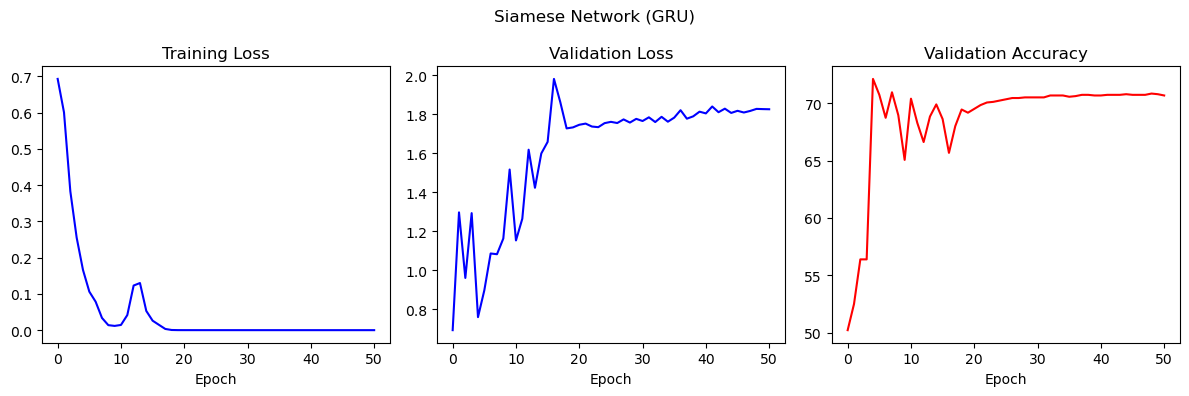

In [114]:
view_training_graphs(siamese_model_training_loss, siamese_model_validation_loss, siamese_model_validation_accuracy, 'Siamese Network (GRU)')